In [1]:
import yaml
import torch
import numpy as np
from pathlib import Path
from scripts.utils import DataLoader
from models.transformer import Transformer
from models.genfactor import GenFactor
from models.mlp import MLP
import pandas as pd
import os
from tqdm import tqdm

# WORK_PATH = Path.cwd()
# FILE_PATH = WORK_PATH / Path('configs/mlp.yml')
# print(FILE_PATH)
# with open(FILE_PATH, 'r') as file:
#     args = yaml.safe_load(file)
# dl = DataLoader(args, 'cuda')
# model = MLP('MLP32',dl, args)

/content/drive/MyDrive/colab/AFP-GenFactor


In [2]:
# Load data
target = '1d_return'
df = pd.read_csv('data/Data_With_Residual_New.csv')
fac_name = [f for f in df.columns if f not in ['Ticker','1d_return', '5d_return', '1d_residual_return', '1d_predict_return', 'Date']]
category = [f for f in df.columns if df[f].dtypes in ['bool', 'int64']]

df= df.dropna(subset=[target]) # drop nan in label, feature
buffer = False
to_clean = [f for f in fac_name if f not in category]
def cross_section_norm(df):
    '''
    cross section normalization
    '''
    z_score = (df - df.mean())/df.std()
    z_score[z_score>3] = 3
    z_score[z_score<-3] = -3
    return z_score

df[to_clean] = df.groupby('Date')[to_clean].apply(cross_section_norm)
def cross_section_norm_category(df):
    '''
    cross section normalization for categorical data
    '''
    if df.dtypes.all() == 'bool':
        return df.astype(int)
    else:
        return cross_section_norm(df + np.random.normal(0, 0.01, df.shape))
df[category] = df.groupby('Date')[category].apply(cross_section_norm_category) # convert categorical feature to [0,1]
df[target] = df.groupby('Date')[target].apply(cross_section_norm) # convert label to [-3,3], we only care cross-section ranking

df.to_csv(f'data/cleaned_data_{target}.csv', index=False)

In [2]:
model.reset_weight()
model.refit()

In [3]:
model.train_model()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


train period ['2006-02-03', '2011-02-04'] valid period ['2011-02-07', '2013-02-25']


2024-02-23 00:42:00.217115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 00:42:00.217162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 00:42:00.218701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 00:42:01.594522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type        | Params
--------------------------------------------
0 | encoder     | Linear  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [10]:
import time
import json
def inference_and_predict(model):
    gBar = tqdm(
            range((len(model.dl.date) - 1260)//252),
            colour="red",
            desc=f"{model.name} Inferencing & Predicting",
        )
    pred_result = []
    label_result = []
    date_result = []
    for g in gBar:
        try: # ugly but works
            model.reset_weight()
            model.refit()
            gBar.set_postfix({"Year": int(model.test_period[0][:4])})
            # model.train_model()
            pred, label, date = model.predict()
            pred_result+=pred
            label_result+=label
            date_result+=date
        except:
            pass
    pred_result = pd.concat(pred_result,axis=1)
    label_result = pd.concat(label_result, axis=1)
    pred_result.columns, label_result.columns = date_result, date_result
    pred_result.to_csv(model.save_path+'prediction'+f'/{model.name}.csv')
    label_result.to_csv(model.save_path+'label'+f'/{model.name}.csv')

    # cal metrics
    oos_prediction_R2 = 1 - (np.nansum((pred_result - label_result)**2)/ np.nansum(label_result**2))
    IC = []
    for col in pred_result.columns:
        IC.append(np.corrcoef(pred_result[col].dropna(), label_result[col].dropna())[1,0])
    
    # save IC & R_square to json
    p = time.localtime()
    time_str = "{:0>4d}-{:0>2d}-{:0>2d}_{:0>2d}-{:0>2d}-{:0>2d}".format(
        p.tm_year, p.tm_mon, p.tm_mday, p.tm_hour, p.tm_min, p.tm_sec
    )
    filename = f"IC_R_squares/{time_str}.json"
    obj = {
        "models": model.name,
        "R2_pred": oos_prediction_R2,
        "IC_pred": np.nanmean(IC),
    }

    with open(filename, "w") as out_file:
        json.dump(obj, out_file)

In [11]:
model = Transformer('TransWithoutOutputNorm',dl, args)
print(model.train_period)
inference_and_predict(model)

['2005-11-19', '2006-01-01']


TransWithoutOutputNorm Inferencing & Predicting: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s, Year=2023]


In [14]:
pred = pd.read_csv('results/prediction/TransWithoutOutputNorm.csv', index_col=0)

In [16]:
label = pd.read_csv('results/label/TransWithoutOutputNorm.csv', index_col=0)

<Axes: title={'center': 'coverage'}>

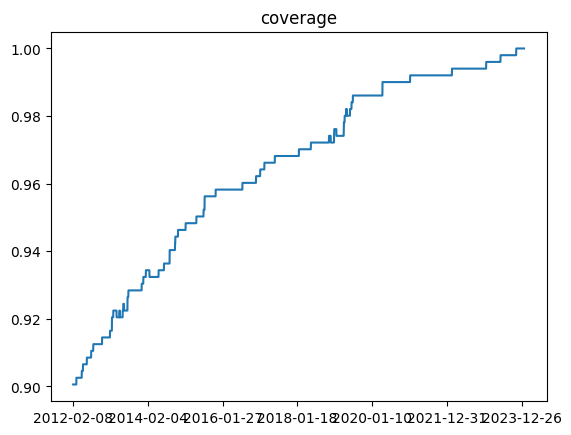

In [28]:
(1 - label.isna().sum()/503).plot(title='coverage')

In [29]:
a,b,c,d = dl[100]

In [30]:
c.shape

torch.Size([82, 417, 20])